In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from timeseries.data import Data


data_class = Data()

train_len, data = data_class.fwd()

[*********************100%%**********************]  1 of 1 completed


In [3]:
data = torch.Tensor(data).view(-1, 1)

In [4]:
train, test = data[:train_len], data[train_len:]

In [5]:
from timeseries.constants import PREV


def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.stack(targets)

seq_length = PREV  # Length of input sequences
train_sequences, train_targets = create_sequences(train, seq_length)
test_sequences, test_targets = create_sequences(test, seq_length)

In [6]:
from timeseries.constants import HIDDEN_SIZE


input_size = 1
hidden_size = HIDDEN_SIZE
num_layers = 2
output_size = 1

In [7]:
from timeseries.constants import LR
from timeseries.torch_model import TorchRNN


model = TorchRNN(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [8]:
from tqdm import trange

from timeseries.constants import EPOCHS


num_epochs = EPOCHS
for epoch in trange(num_epochs):
    for i in range(len(train_sequences)):
        inputs, target = train_sequences[i].unsqueeze(0), train_targets[i].unsqueeze(0)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


In [9]:
preds = []

window = torch.tensor(train[-PREV:])

model.eval()
with torch.no_grad():
    predicted_prices = []
    for i in range(len(test)):
        x = window.reshape(1, PREV, 1)
        new_tick = model(x)
        
        window = window.numpy().tolist()
        
        window.append([new_tick.item()])
        window = torch.tensor(window[1:])
        
        preds.append(new_tick.item())

/tmp/ipykernel_72671/2605822629.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window = torch.tensor(train[-PREV:])


In [10]:
preds = np.array(preds)
test = test.numpy()

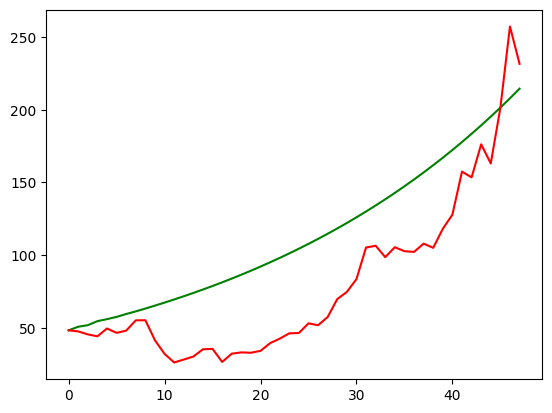

In [11]:
preds = data_class.bkwd(preds)
test = data_class.bkwd(test)

plt.plot(preds, 'g')
plt.plot(test, 'r')
plt.show()

In [12]:
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(preds, test))

40.67886576402192